# Robustness checks for phi_0

This notebook contains a few robustness checks for phi_0, the score on the first principal component. It investigates whether swapping out that variable for another variable has significant effects on the resulting patterns in the GAM.

The notebook `Create_figures` should be run before running this notebook.

## Preliminaries

Make the width of the cells 100%:

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
from pathlib import Path
import time
from copy import copy
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import seaborn as sns

from pandas_datareader import wb

from scipy.linalg import eig
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cosine as cosine_distance
from scipy.stats import pearsonr
from scipy.stats import norm as norm_rv

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score


import pygam
from pygam.utils import generate_X_grid

scripts_path = os.path.abspath(os.path.join(os.pardir, 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from load_data.load_exports_data import load_and_filter_CID_S2_trade_data
from load_data.normalize_by_population import DivideByPopulationPowerLaw
from load_data.load_exports_data import create_panel_from_long_data
from analyze_panel_data.utils import panel_to_multiindex, panel_to_multiindex_drop_missing, multiindex_to_panel
from analyze_panel_data.preprocessing.dimension_reduction import PCAsomeColumns
from analyze_panel_data.preprocessing.scalers import ScaledLogPositiveData
from analyze_panel_data.model_selection.train_test_split import MultiTimeSeriesSplit
from analyze_panel_data.models import SKLearnPanelModel
from analyze_panel_data.model_selection import create_random_search
from analyze_panel_data.model_selection.random_variables import (
    loguniform_dist, uniform_dist, LogUniformDistribution,
    ContinuousUniformDistribution, IntegerUniformDistribution,
    DiscreteChoice)
import analyze_panel_data.visualization.inferred_model as vis_model
import analyze_panel_data.visualization.dimension_reduction as vis_dim_red
from predict_growth.predict_gdppc import append_gdppc, load_gdp_per_capita_nonmissing

# Seed the random number generator for reproducibility
np.random.seed(1)

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### information about the SITC classification

In [7]:
PROJECT_DIR = Path('..')
RAW_DATA_DIR = PROJECT_DIR / 'data' / 'raw'
sitc_classifications = pd.read_excel(RAW_DATA_DIR / 'classifications.xlsx', sheetname='sitc_product_id', index_col=0)
sitc_classifications = sitc_classifications.rename(columns={'sitc_product_code': 'code', 'sitc_product_name_short_en': 'name_short_en'})
sitc_classifications = sitc_classifications.query('code != "ZZZZ"')  # code ZZZZ is the code for unknown products

product_code_to_name = sitc_classifications.set_index('code')['name_short_en']

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb


sitc_colors = {
    str(code): rgb_to_hex(color)
    for code, color in enumerate([
        (78, 154, 84),
        (76, 76, 76),
        (34, 169, 163),
        (109, 86, 87),
        (0, 74, 47),
        (112, 23, 75),
        (223, 36, 42),
        (160, 218, 228),
        (15, 101, 44),
        (156, 153, 136),
    ])}

sitc_classifications = sitc_classifications.assign(
    color_1digitlevel=sitc_classifications.code.apply(
        lambda code4digit: sitc_colors.get(code4digit[0], 'k')))
product_code_to_1digit_color = sitc_classifications.set_index('code')['color_1digitlevel']

#### configuration of plots

In [37]:
ONE_COL_WIDTH = 8.7 / 2.54
TWO_COL_WIDTH = 8.7 * 2 / 2.54

plt.style.use('seaborn-white')
plt.rc('font', family='DejaVu Sans', serif='Times', size=8)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', labelsize=8)
annotate_text_size = 8

VARIABLE_NOTATION = dict(
    score_pc0=r'\phi_0',
    score_pc1=r'\phi_1',
    score_pc2=r'\phi_2',
    gdppc=r'\texttt{GDPpc}',
    link='g',
    smooth_term='s',
    rca_math='R',
    export_value_math='X',
)

BBOX_LABELS = dict(fc="0.9", ec=".8", lw=1, boxstyle='round,pad=0.18')

Path for figures:

In [9]:
path_manuscript_figures = os.path.join(os.pardir, 'figures')
os.makedirs(path_manuscript_figures, exist_ok=True)

Path to data:

In [10]:
path_to_data = Path('..', 'data')
path_to_processed_data = path_to_data / 'processed'

### Extract and filter exports data

To extract the data from this file and filter the products and countries, run the following cell:

In [11]:
path_to_exports_data = RAW_DATA_DIR / 'S2_final_cpy_all.dta'
data_from_CID, exports_long_format, panel_export_value = (
    load_and_filter_CID_S2_trade_data(str(path_to_exports_data), product_code_digits=2))

81 countries with population < 1250000.0 in year 2008: ['ABW', 'AIA', 'AND', 'ANS', 'ANT', 'ASM', 'ATA', 'ATF', 'ATG', 'BHR', 'BHS', 'BLZ', 'BMU', 'BRB', 'BRN', 'BTN', 'BVT', 'CCK', 'COK', 'COM', 'CPV', 'CXR', 'CYM', 'CYP', 'DJI', 'DMA', 'ESH', 'FJI', 'FLK', 'FRO', 'FSM', 'GIB', 'GNQ', 'GRD', 'GRL', 'GUM', 'GUY', 'IOT', 'ISL', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MNE', 'MNP', 'MSR', 'MUS', 'MYT', 'NCL', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'SGS', 'SHN', 'SLB', 'SMR', 'SPM', 'STP', 'SUR', 'SWZ', 'SYC', 'TCA', 'TKL', 'TLS', 'TON', 'TUV', 'TWN', 'UMI', 'VAT', 'VCT', 'VGB', 'VUT', 'WLF', 'WSM']

If countries and products were removed now, this is the number of products with zero global exports in at least one year: 16



81 countries with exports < 1000000000.0 in year 2008: ['AFG', 'AIA', 'AND', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'BDI', 'BEN', 'BFA', 'BLZ', 'BRB', 'BTN', 'BVT', 'CAF', 'CCK', 'COK', 'COM', 'CPV', 'CXR', 'CYM', 'DJI', 'DMA', 'ERI', 'ESH', 'FJI', 'FL

### Load population data from the World Bank

In [12]:
from load_data.download_population_data import load_population_data_from_World_Bank_and_CID

In [13]:
start_year = data_from_CID.year.min()
end_year = data_from_CID.year.max()

In [14]:
population_data = load_population_data_from_World_Bank_and_CID(data_from_CID)

In [15]:
population_data.shape

(55, 216)

### Normalize by population-based null model

In [16]:
div_pop = DivideByPopulationPowerLaw()
div_pop.fit(panel_export_value, wide_population_data=population_data)
rpop_panel = div_pop.transform(panel_export_value)

rpop_df = panel_to_multiindex_drop_missing(rpop_panel, fillna=0.0)
rpop_df.name = 'export_value'
rpop_df.filename = 'export_value'

Check that no rows are all zero and no entries in the dataframe are empty:

In [17]:
assert (rpop_df == 0.0).all(1).sum() == 0  # No rows are all zero
assert rpop_df.isnull().sum().sum() == 0  # No entries are empty

#### Fraction of the global population in this dataset

Here, we create a figure that illustrates what fraction of the global population is in the data.

To do so, we first download data on global population from the World Bank:

In [18]:
global_population_data = wb.download(
    indicator='SP.POP.TOTL',
    start=1962, end=2016, country='all').loc['World'].sort_index().rename(columns={'SP.POP.TOTL': 'global_population'})

global_population_data.index = pd.to_datetime(
    global_population_data.index, format="%Y").astype('period[A-DEC]')

population_data_WB_and_CID_long = population_data.stack()
population_data_WB_and_CID_long.index.names = ['year', 'country_code']
population_data_WB_and_CID_long = population_data_WB_and_CID_long.reorder_levels(['country_code', 'year'])
frac_global_pop = population_data_WB_and_CID_long.loc[rpop_df.index.values].sum(level=1).div(global_population_data.global_population)

global_exports = data_from_CID.groupby('year')['export_value'].sum()
global_exports.index = pd.to_datetime(
    global_exports.index, format="%Y").astype('period[A-DEC]')
frac_global_exports = panel_to_multiindex(panel_export_value).loc[rpop_df.index.values].sum(1).sum(level=1) / global_exports

#### Do the transformation

In [19]:
log_scaler = ScaledLogPositiveData(X_min_pos=None)
log_scaler.fit(rpop_df)
rpop_df_log_scaled = log_scaler.transform(rpop_df)

## Preprocessing

This is the same preprocessing done in the `Create_figures` notebook used to create the figures in the main text. 

### Logarithmic scaling

In [24]:
def scale_to_pre1988(df, scaler):
    scaler.fit(slice_training_set_for_preprocessing(df))
    return pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns), scaler

def slice_training_set_for_preprocessing(df):
    return df.loc[(slice(None), slice('1962', '1988')), :]

In [21]:
log_scaler = ScaledLogPositiveData(X_min_pos=None)
log_scaler.fit(rpop_df)
rpop_df_logged = log_scaler.fit_transform(rpop_df)

rpop_df_logged_scaled, scaler = scale_to_pre1988(rpop_df_logged, StandardScaler())

### Transform the target `y` to  `np.abs(y)**root * np.sign(y)`

In [22]:
def signed_root(x, root=0.5):
    return np.abs(x)**root * np.sign(x)


def inverse_of_signed_root(x, root=0.5):
    return np.abs(x)**(1 / root) * np.sign(x)


def signed_root_transformer(root=0.5):
    t = FunctionTransformer(
        func=signed_root,
        inverse_func=inverse_of_signed_root,
        kw_args={'root': root}, inv_kw_args={'root': root})
    name = 'signed_root_transformer_root={}'.format(root)
    t.name = name
    t.filename = name
    return t

### Create the train–test splits

In [26]:
rpop_df_logged_scaled.name = rpop_df_logged_scaled.filename = 'Rpop_ScalePopulationPowerLaw_ScaleLogPositive'
pca = PCAsomeColumns(
    n_components=2, exclude_columns='log10_gdp_per_capita_constant2010USD')

mtss = MultiTimeSeriesSplit(
    n_train_test_sets=5,
    first_split_fraction=.389891,  # chosen to make all data before 1988 in the first training set
    level_of_index_for_time_values='year')

def make_model():
    return create_random_search(
        MultiOutputRegressor(pygam.GAM()),
        [
            IntegerUniformDistribution(15, 60, 'estimator', 'n_splines'),
            LogUniformDistribution(-3.0, 10.0, 'estimator', 'lam'),
        ],
        n_iter=150,
        cv=mtss)

panel = multiindex_to_panel(append_gdppc(rpop_df_logged_scaled))
panel.name = rpop_df.name
panel.filename = rpop_df.filename

### Create the object containing the model and data

In [27]:
pm = SKLearnPanelModel(
    panel, make_model(),
    model_predicts_change=True,
    dim_reducer_preprocessing=pca,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),)

/Users/charliebrummitt/OneDrive - INDIGO AG, INC/code/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:429: UserWarning: A directory already exists at the results path results/24b3f41a3f28b4ef3b480373cb2fe29d47686b6f9a57010b4ab2f78a05ffb444. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


Since this model was already fitted in the notebook `Create_figures`, we can simply load the results of the random hyperparameter search here:

In [28]:
pm.load_best_model()
pm.split_best_model_into_dimension_reducer_and_predictor()

Loading the best model found in path results/24b3f41a3f28b4ef3b480373cb2fe29d47686b6f9a57010b4ab2f78a05ffb444/best_model/best_model.pkl


We already saw these streamplots in the right-hand column of Figure 4:

Text(0,0.5,'GDP per capita')

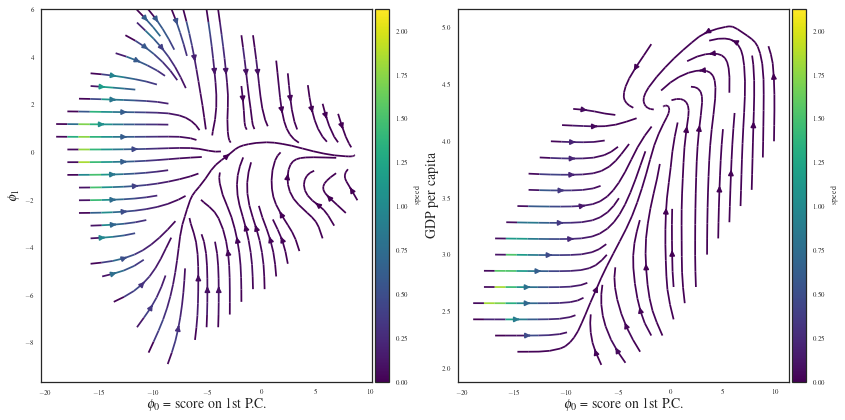

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH * 2, TWO_COL_WIDTH))
pm.plot_predictions_of_model_in_2D(ax=ax[0], dimensions_to_keep=(0, 1),)
ax[0].set_xlabel(r'${score_pc0}$ = score on 1st P.C.'.format(**VARIABLE_NOTATION), size=14)
ax[0].set_ylabel(r'${score_pc1}$'.format(**VARIABLE_NOTATION), size=14)
pm.plot_predictions_of_model_in_2D(ax=ax[1], dimensions_to_keep=(0, 2),)
ax[1].set_xlabel(r'${score_pc0}$ = score on 1st P.C.'.format(**VARIABLE_NOTATION), size=14)
ax[1].set_ylabel('GDP per capita', size=14)

## _Robustness check 1_: Replace phi_0 with export value per capita

Here, we investigate what happens when we swap phi_0 with total export value per capita in the GAM.

### Compute export value per capita

In [30]:
# Export value per capita
total_export_value_per_capita_wide = panel_export_value.sum('minor_axis').div(population_data, axis=1)

total_export_value_per_capita_long = (
    total_export_value_per_capita_wide
    .stack()#.reset_index()
    .to_frame()
    .rename(columns={0: 'export_value_per_capita'})
    .query('export_value_per_capita > 0'))

panel_with_exports_per_capita = multiindex_to_panel(append_gdppc(pd.merge(
    rpop_df_logged_scaled.reset_index(),
    (total_export_value_per_capita_long.apply(np.log10)
     .rename(columns={'export_value_per_capita': 'log10_export_value_per_capita'}).reset_index()),
    on=['year', 'country_code']).set_index(['year', 'country_code'])))

Here, we define a new dimension reduction class `PCAgrabSomeColumns` that is similar to the class `PCAsomeColumns` used to make the results in the main manuscript. The constructor for `PCAgrabSomeColumns` has two additional keyword arguments, `keep_components` and `column_order`, that enable us to swap out the column containing the scores on the first principal component with some other column. This is a kludge that gets the job done; a more elegant solution would use [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).

In [31]:
def list_wrap(x):
    if isinstance(x, str):
        return [x]
    try:
        return list(x)
    except TypeError:
        return [x]

class PCAgrabSomeColumns(PCA):
    """PCA that doesn't transform some columns. Works only with DataFrames.

    It also standardizes the signs of the loadings (which are arbitrary) so
    that the mean of each loading vector is positive.
    """

    def __init__(self, exclude_columns=None, n_components=None, keep_components=None, column_order=None,
                 copy=True, whiten=False, svd_solver='auto', tol=0.0,
                 iterated_power='auto', random_state=None):
        if exclude_columns is None:
            self.exclude_columns = []
        else:
            self.exclude_columns = list_wrap(exclude_columns)
        self.keep_components = keep_components
        self.column_order = column_order
        super(PCAgrabSomeColumns, self).__init__(
            n_components=n_components,
            copy=True, whiten=whiten,
            svd_solver=svd_solver, tol=tol,
            iterated_power=iterated_power,
            random_state=random_state)

    @property
    def filename(self):
        filename = 'PCAsomeColumns_n_components={}'.format(self.n_components)
        if len(self.exclude_columns) > 0:
            filename += (
                '_exclude_columns_' +
                '_'.join(col for col in self.exclude_columns))
        return filename

    def fit(self, X, y=None):
        self.include_columns = [
            c for c in X.columns.values if c not in self.exclude_columns]
        super(PCAgrabSomeColumns, self).fit(X.loc[:, self.include_columns])
        for i, loadings in enumerate(self.components_):
            # Standardize the signs (which are arbitary) so that mean(loadings)
            # is positive
            self.components_[i] *= np.sign(np.mean(loadings))

    def transform(self, X, y=None):
        X_transformed = super(PCAgrabSomeColumns, self).transform(
            X.loc[:, self.include_columns])
        transformed_by_pca = pd.DataFrame(
            X_transformed,
            columns=['component_{}'.format(i)
                     for i in range(self.n_components)],
            index=X.index)
        if self.keep_components is not None:
            transformed_by_pca = transformed_by_pca.loc[:, self.keep_components]
        result = pd.concat(
            [transformed_by_pca, X.loc[:, self.exclude_columns]], axis=1)
        if self.column_order is not None:
            return result.loc[:, self.column_order]
        return result

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

    def inverse_transform(self, X, y=None):
        raise NotImplementedError()
#         X_inverse_transformed = super(PCAsomeColumns, self).inverse_transform(
#             X.loc[:, [c for c in X.columns.values
#                       if c not in self.exclude_columns]])
#         X_inverse_transformed = pd.DataFrame(
#             X_inverse_transformed,
#             columns=self.include_columns,
#             index=X.index)
#         result = pd.concat(
#             [X_inverse_transformed, X.loc[:, self.exclude_columns]], axis=1)
#         return result

In [32]:
pca_for_exports_per_capita = PCAgrabSomeColumns(
    n_components=2, exclude_columns=['log10_gdp_per_capita_constant2010USD', 'log10_export_value_per_capita'],
    keep_components=['component_1'],
    column_order=['log10_export_value_per_capita', 'component_1', 'log10_gdp_per_capita_constant2010USD'])

pm_exports_per_capita = SKLearnPanelModel(
    panel_with_exports_per_capita,
    make_model(),
    model_predicts_change=True,
    dim_reducer_preprocessing=pca_for_exports_per_capita,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),)

/Users/charliebrummitt/OneDrive - INDIGO AG, INC/code/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:429: UserWarning: A directory already exists at the results path results/5e82e501cc5aed8d5daf9da744513a18b7e46ba1a065b84b6f31523c268dab99. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


#### fit models

In [33]:
pm_exports_per_capita.fit_model_to_entire_dataset_and_save_best_model()

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-f

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

Fit time: 598.275661945343 seconds = 0:09:58.275662


/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


598.275661945343

Run this to load the best model:

In [ ]:
pm_exports_per_capita.load_best_model()

In [34]:
pm_exports_per_capita.split_best_model_into_dimension_reducer_and_predictor()

### visualize streamplots

#### exports per capita

Text(0,0.5,'GDP per capita')

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/matplotlib/font_manager.

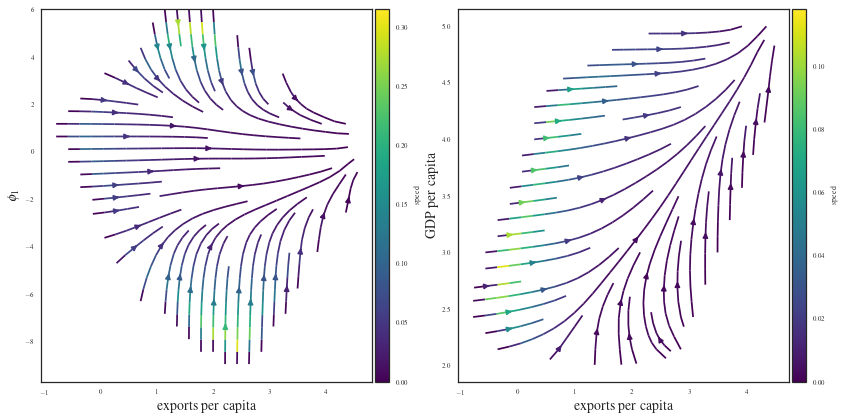

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH * 2, TWO_COL_WIDTH))
pm_exports_per_capita.plot_predictions_of_model_in_2D(ax=ax[0], dimensions_to_keep=(0, 1),)
ax[0].set_xlabel('exports per capita', size=14)
ax[0].set_ylabel(r'${score_pc1}$'.format(**VARIABLE_NOTATION), size=14)
pm_exports_per_capita.plot_predictions_of_model_in_2D(ax=ax[1], dimensions_to_keep=(0, 2),)
ax[1].set_xlabel('exports per capita', size=14)
ax[1].set_ylabel('GDP per capita', size=14)

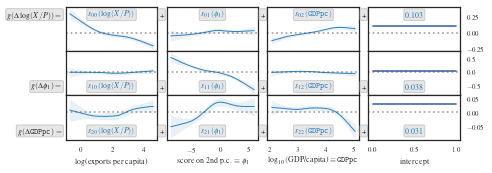

In [40]:
fig, ax = plt.subplots(3, 4, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .4), sharex='col', sharey='row')
handles = []

label_kws = dict(
    bbox=BBOX_LABELS,
    xycoords='axes fraction',
    ha='center', va='center')

terms = [
#     VARIABLE_NOTATION['score_pc0'],
    '\log(X/P)',
    VARIABLE_NOTATION['score_pc1'],
    VARIABLE_NOTATION['gdppc'],
]
pms = [pm_exports_per_capita]
symbol_heights = [.82, .2, .2]#[.82] * 3# [.7, .7, .88]
for pm_index, (pm, color, linestyle) in enumerate(zip(pms, list(mpl.colors.TABLEAU_COLORS.values())[:3], ['-', '--', ':'])):
    gams = pm.best_model.estimators_
    for i, gam in enumerate(np.array(gams)):
        X_grid = generate_X_grid(gam)
        partial_dependence, confidence_interval = gam.partial_dependence(
            X_grid, width=.95)
        for j in range(4):
            if j < 3:
                lines, = ax[i, j].plot(X_grid[:, j], partial_dependence[:, j],
                                       color=color, lw=1, alpha=.9, linestyle=linestyle)
                ax[i, j].fill_between(X_grid[:, j], *confidence_interval[j].T, color=color, alpha=.1)
                title = '$s_{{{i}{j}}}({term})$'.format(i=i, j=j, term=terms[j])
                if pm_index == 0:
                    ax[i, j].annotate(s=title, xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)

            if i == 0 and j == 0:
                handles.append(lines)
            if j == 3:
                ax[i, j].plot([0, 1], [gam.coef_[0]] * 2, ls='-')
                ax[i, j].annotate(s='{:.3f}'.format(gam.coef_[0]), xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)
            ax[i, j].axhline(0, color='.3', alpha=.5, ls=':')

ylabel_kws = dict(rotation=0, size=12, x=-.1)
ax[2, 1].set_xlabel(r'score on 2nd p.c. $\equiv {score_pc1}$'.format(**VARIABLE_NOTATION))
ax[2, 2].set_xlabel(r'$\log_{{10}}($' + 'GDP/capita' + r') \equiv {gdppc}$'.format(**VARIABLE_NOTATION))
ax[2, 0].set_xlabel('log(exports per capita)')
ax[2, 3].set_xlabel('intercept')

for i, term in enumerate(terms):
    ax[i, 0].annotate(s=r'$g(\Delta {}) =$'.format(term),
                      xy=(-.04, symbol_heights[i]), **{**label_kws, 'ha': 'right'})
for i in range(3):
    for j in range(3):
        ax[i, j].annotate(s='+', xy=(1.05, symbol_heights[i]), **label_kws)
fig.subplots_adjust(top=.8, left=.1, wspace=.1, hspace=0.0)

for i in range(3):
    ax[i, 0].tick_params(axis='y', left=True, labelleft=False)
    ax[i, 3].tick_params(axis='y', right=True, labelright=True)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'partial_dependence_exports_per_capita.pdf'), dpi=300, bbox_inches='tight')

## _Robustness check 2_: Replace phi_0 with diversification

Here, we swap phi_0 with diversification, defined as the sum of revealed comparative advantage (RCA) over all products.

### Compute diversification

In [41]:
def compute_revealed_comparative_advantage(panel):
    """Compute Revealed Comparative Advantage in a panel of export values.

    Given a panel dataset of export values, with items as countries,
    time as major_axis, and products as minor_axis, create a new panel
    containing the revealed comparative advantage.
    """
    export_rca_panel = panel.copy()

    # Sum exports over all countries (sum_c X_cpt)
    export_market_size_by_year_and_product = panel.sum(axis='items')

    # Series of the total global exports each year (sum_cp X_cpt)
    export_market_size_by_year = panel.sum(axis='items').sum(axis='columns')

    for country in panel.items:
        export_rca_panel.loc[country] = (
            panel.loc[country]
                 # Divide by the size of the export basket of this country
                 .div(panel.loc[country].sum(axis='columns'), axis=0)
                 # Multiply by the size of the global exports in each year
                 .mul(export_market_size_by_year, axis=0)
                 # Divide by the size of the product market size in each year
                 .div(export_market_size_by_year_and_product))

    return export_rca_panel

rca_panel_2digits = compute_revealed_comparative_advantage(panel_export_value)

In [42]:
diversification_2digits = pd.DataFrame((rca_panel_2digits > 1).sum(axis='minor_axis').stack(), columns=['diversification_RCA'])

panel_with_diversification = multiindex_to_panel(append_gdppc(pd.merge(
    rpop_df_logged_scaled.reset_index(), diversification_2digits.reset_index(),
    on=['year', 'country_code']).set_index(['year', 'country_code'])))

### Make the model

In [43]:
pca_for_diversification = PCAgrabSomeColumns(
    n_components=2, exclude_columns=['log10_gdp_per_capita_constant2010USD', 'diversification_RCA'],
    keep_components=['component_1'],
    column_order=['diversification_RCA', 'component_1', 'log10_gdp_per_capita_constant2010USD'])

pm_diversification = SKLearnPanelModel(
    panel_with_diversification,
    make_model(),
    model_predicts_change=True,
    dim_reducer_preprocessing=pca_for_diversification,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),)

/Users/charliebrummitt/OneDrive - INDIGO AG, INC/code/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:429: UserWarning: A directory already exists at the results path results/c0e5ba93091b65fe6f9a73aae095bf39514297d129ba0ca069ddf5960ea8a7ca. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


In [44]:
pm_diversification.fit_model_to_entire_dataset_and_save_best_model()

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-f

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

Fit time: 560.1803078651428 seconds = 0:09:20.180308


560.1803078651428

In [45]:
pm_diversification.split_best_model_into_dimension_reducer_and_predictor()

### streamplot

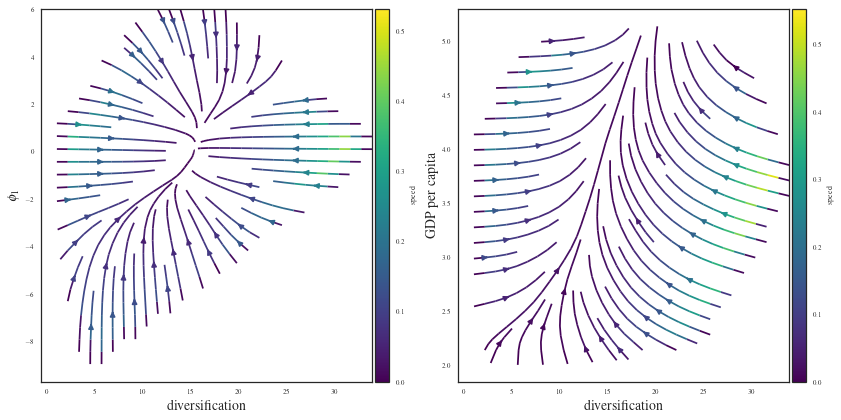

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH * 2, TWO_COL_WIDTH))
pm_diversification.plot_predictions_of_model_in_2D(ax=ax[0], dimensions_to_keep=(0, 1),)
ax[0].set_xlabel('diversification', size=14)
ax[0].set_ylabel(r'${score_pc1}$'.format(**VARIABLE_NOTATION), size=14)
pm_diversification.plot_predictions_of_model_in_2D(ax=ax[1], dimensions_to_keep=(0, 2),)
ax[1].set_xlabel('diversification', size=14)
ax[1].set_ylabel('GDP per capita', size=14)
plt.show()

### partial dependence plot

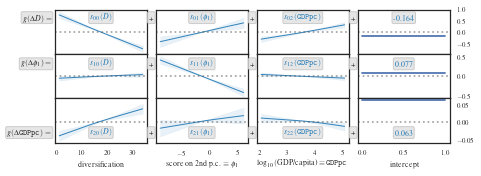

In [47]:
fig, ax = plt.subplots(3, 4, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .4), sharex='col', sharey='row')
handles = []

label_kws = dict(
    bbox=BBOX_LABELS,
    xycoords='axes fraction',
    ha='center', va='center')

terms = [
#     VARIABLE_NOTATION['score_pc0'],
    'D',
    VARIABLE_NOTATION['score_pc1'],
    VARIABLE_NOTATION['gdppc'],
]
pms = [pm_diversification]
symbol_heights = [.82, .78, .23]#[.82] * 3# [.7, .7, .88]
for pm_index, (pm, color, linestyle) in enumerate(zip(pms, list(mpl.colors.TABLEAU_COLORS.values())[:3], ['-', '--', ':'])):
    gams = pm.best_model.estimators_
    for i, gam in enumerate(np.array(gams)):
        X_grid = generate_X_grid(gam)
        partial_dependence, confidence_interval = gam.partial_dependence(
            X_grid, width=.95)
        for j in range(4):
            if j < 3:
                lines, = ax[i, j].plot(X_grid[:, j], partial_dependence[:, j],
                                       color=color, lw=1, alpha=.9, linestyle=linestyle)
                ax[i, j].fill_between(X_grid[:, j], *confidence_interval[j].T, color=color, alpha=.1)
                title = '$s_{{{i}{j}}}({term})$'.format(i=i, j=j, term=terms[j])
                if pm_index == 0:
                    ax[i, j].annotate(s=title, xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)

            if i == 0 and j == 0:
                handles.append(lines)
            if j == 3:
                ax[i, j].plot([0, 1], [gam.coef_[0]] * 2, ls='-')
                ax[i, j].annotate(s='{:.3f}'.format(gam.coef_[0]), xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)
            ax[i, j].axhline(0, color='.3', alpha=.5, ls=':')

ylabel_kws = dict(rotation=0, size=12, x=-.1)
ax[2, 1].set_xlabel(r'score on 2nd p.c. $\equiv {score_pc1}$'.format(**VARIABLE_NOTATION))
ax[2, 2].set_xlabel(r'$\log_{{10}}($' + 'GDP/capita' + r') \equiv {gdppc}$'.format(**VARIABLE_NOTATION))
ax[2, 0].set_xlabel('diversification')
ax[2, 3].set_xlabel('intercept')

for i, term in enumerate(terms):
    ax[i, 0].annotate(s=r'$g(\Delta {}) =$'.format(term),
                      xy=(-.04, symbol_heights[i]), **{**label_kws, 'ha': 'right'})
for i in range(3):
    for j in range(3):
        ax[i, j].annotate(s='+', xy=(1.05, symbol_heights[i]), **label_kws)
fig.subplots_adjust(top=.8, left=.1, wspace=.1, hspace=0.0)

for i in range(3):
    ax[i, 0].tick_params(axis='y', left=True, labelleft=False)
    ax[i, 3].tick_params(axis='y', right=True, labelright=True)
fig.savefig(os.path.join(
    path_manuscript_figures,
    'partial_dependence_diversification.pdf'), dpi=300, bbox_inches='tight')

## _Robustness check 3_: Replace the first component by a loading vector of all ones

As a final robustness check, we see how important it is that the loadings of the first principal component appear to be correlated with some notion of complexity of the product. To do that, we artificially replace the loadings of the first principal component with a vector of all ones:

In [48]:
class PCAmakeFirstComponentAllOnes(PCA):
    """PCA modified so that that doesn't transform some columns and makes the first component all ones.
    """

    def __init__(self, exclude_columns=None, n_components=None, keep_components=None, column_order=None,
                 copy=True, whiten=False, svd_solver='auto', tol=0.0,
                 iterated_power='auto', random_state=None):
        if exclude_columns is None:
            self.exclude_columns = []
        else:
            self.exclude_columns = list_wrap(exclude_columns)
        self.keep_components = keep_components
        self.column_order = column_order
        super(PCAmakeFirstComponentAllOnes, self).__init__(
            n_components=n_components,
            copy=True, whiten=whiten,
            svd_solver=svd_solver, tol=tol,
            iterated_power=iterated_power,
            random_state=random_state)

    @property
    def filename(self):
        filename = 'PCAsomeColumns_n_components={}'.format(self.n_components)
        if len(self.exclude_columns) > 0:
            filename += (
                '_exclude_columns_' +
                '_'.join(col for col in self.exclude_columns))
        return filename

    def fit(self, X, y=None):
        self.include_columns = [
            c for c in X.columns.values if c not in self.exclude_columns]
        super(PCAmakeFirstComponentAllOnes, self).fit(X.loc[:, self.include_columns])
        self.components_[0] = np.ones_like(self.components_[0])
        for i, loadings in enumerate(self.components_):
            # Standardize the signs (which are arbitary) so that mean(loadings)
            # is positive
            self.components_[i] *= np.sign(np.mean(loadings))

    def transform(self, X, y=None):
        X_transformed = super(PCAmakeFirstComponentAllOnes, self).transform(
            X.loc[:, self.include_columns])
        transformed_by_pca = pd.DataFrame(
            X_transformed,
            columns=['component_{}'.format(i)
                     for i in range(self.n_components)],
            index=X.index)
        if self.keep_components is not None:
            transformed_by_pca = transformed_by_pca.loc[:, self.keep_components]
        result = pd.concat(
            [transformed_by_pca, X.loc[:, self.exclude_columns]], axis=1)
        if self.column_order is not None:
            return result.loc[:, self.column_order]
        return result

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

    def inverse_transform(self, X, y=None):
        raise NotImplementedError()

In [49]:
rpop_df_logged_scaled.name = rpop_df_logged_scaled.filename = 'Rpop_ScalePopulationPowerLaw_ScaleLogPositive'
pca_first_component_all_one = PCAmakeFirstComponentAllOnes(
    n_components=2, exclude_columns='log10_gdp_per_capita_constant2010USD')
pca_first_component_all_one.name = 'pca_first_component_all_one'
mtss = MultiTimeSeriesSplit(
    n_train_test_sets=5,
    first_split_fraction=.389891,  # chosen to make all data before 1988 in the first training set
    level_of_index_for_time_values='year')


In [50]:
pm_first_component_all_one = SKLearnPanelModel(
    panel, make_model(),
    model_predicts_change=True,
    dim_reducer_preprocessing=pca_first_component_all_one,
    validate_on_full_dimensions=False,
    overwrite_existing_results=True,
    metric=mean_squared_error,
    metric_greater_is_better=False,
    target_transformer=signed_root_transformer(0.5),
    results_directory='check_robustness_phi0')

/Users/charliebrummitt/OneDrive - INDIGO AG, INC/code/machine_learned_patterns_in_economic_development/scripts/analyze_panel_data/models/DimensionReducingPanelModel.py:429: UserWarning: A directory already exists at the results path check_robustness_phi0/24b3f41a3f28b4ef3b480373cb2fe29d47686b6f9a57010b4ab2f78a05ffb444. Continuing anyway (and overwriting results) because `overwrite_existing_results` is `True`.  If you fit the model, it will overwrite the previously saved fit.
  warnings.warn(msg)


In [51]:
pm_first_component_all_one.fit_model_to_entire_dataset_and_save_best_model()

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-f

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-f

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/pygam.py:946: UserWarning: Matrix is not positive definite. 
Increasing l2 reg by factor of 10.
  E = self._cholesky(S + P, sparse=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pyg

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructio

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 38.7min finished
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/anaconda3/envs/id_pat_econ_dev/lib/python3.5/site-packages/pygam/utils.py:68: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotoni

Fit time: 2325.1241760253906 seconds = 0:38:45.124176


2325.1241760253906

In [52]:
pm_first_component_all_one.split_best_model_into_dimension_reducer_and_predictor()

The results seem to be rather similar to the model described in the main text, so it appears that the correlation of the loadings of the first principal component is not key to the behavior of the GAM.

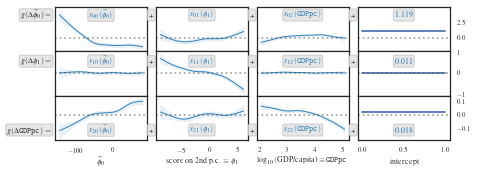

In [56]:
fig, ax = plt.subplots(3, 4, figsize=(TWO_COL_WIDTH, TWO_COL_WIDTH * .4), sharex='col', sharey='row')
handles = []

label_kws = dict(
    bbox=BBOX_LABELS,
    xycoords='axes fraction',
    ha='center', va='center')

terms = [
#     VARIABLE_NOTATION['score_pc0'],
    r'\widetilde ' + VARIABLE_NOTATION['score_pc0'],
    VARIABLE_NOTATION['score_pc1'],
    VARIABLE_NOTATION['gdppc'],
]
pms = [pm_first_component_all_one]
symbol_heights = [.82, .78, .23]#[.82] * 3# [.7, .7, .88]
for pm_index, (pm, color, linestyle) in enumerate(zip(pms, list(mpl.colors.TABLEAU_COLORS.values())[:3], ['-', '--', ':'])):
    gams = pm.best_model.estimators_
    for i, gam in enumerate(np.array(gams)):
        X_grid = generate_X_grid(gam)
        partial_dependence, confidence_interval = gam.partial_dependence(
            X_grid, width=.95)
        for j in range(4):
            if j < 3:
                lines, = ax[i, j].plot(X_grid[:, j], partial_dependence[:, j],
                                       color=color, lw=1, alpha=.9, linestyle=linestyle)
                ax[i, j].fill_between(X_grid[:, j], *confidence_interval[j].T, color=color, alpha=.1)
                title = '$s_{{{i}{j}}}({term})$'.format(i=i, j=j, term=terms[j])
                if pm_index == 0:
                    ax[i, j].annotate(s=title, xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)

            if i == 0 and j == 0:
                handles.append(lines)
            if j == 3:
                ax[i, j].plot([0, 1], [gam.coef_[0]] * 2, ls='-')
                ax[i, j].annotate(s='{:.3f}'.format(gam.coef_[0]), xy=(.5, symbol_heights[i]), color='#1f77b4', **label_kws)
            ax[i, j].axhline(0, color='.3', alpha=.5, ls=':')

ylabel_kws = dict(rotation=0, size=12, x=-.1)
ax[2, 1].set_xlabel(r'score on 2nd p.c. $\equiv {score_pc1}$'.format(**VARIABLE_NOTATION))
ax[2, 2].set_xlabel(r'$\log_{{10}}($' + 'GDP/capita' + r') \equiv {gdppc}$'.format(**VARIABLE_NOTATION))
ax[2, 0].set_xlabel(r'$\widetilde ' + r'{score_pc0}$'.format(**VARIABLE_NOTATION))
ax[2, 3].set_xlabel('intercept')

for i, term in enumerate(terms):
    ax[i, 0].annotate(s=r'$g(\Delta {}) =$'.format(term),
                      xy=(-.04, symbol_heights[i]), **{**label_kws, 'ha': 'right'})
for i in range(3):
    for j in range(3):
        ax[i, j].annotate(s='+', xy=(1.05, symbol_heights[i]), **label_kws)
fig.subplots_adjust(top=.8, left=.1, wspace=.1, hspace=0.0)

for i in range(3):
    ax[i, 0].tick_params(axis='y', left=True, labelleft=False)
    ax[i, 3].tick_params(axis='y', right=True, labelright=True)
# fig.savefig(os.path.join(
#     path_manuscript_figures,
#     'partial_dependence_diversification.pdf'), dpi=300, bbox_inches='tight')

Text(0,0.5,'GDP per capita')

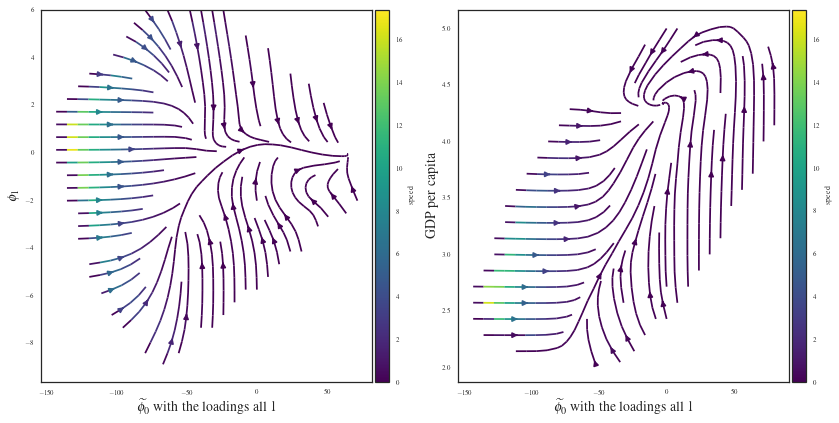

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(TWO_COL_WIDTH * 2, TWO_COL_WIDTH))
pm_first_component_all_one.plot_predictions_of_model_in_2D(ax=ax[0], dimensions_to_keep=(0, 1),)
ax[0].set_xlabel(r'$\widetilde {score_pc0}$ with the loadings all 1'.format(**VARIABLE_NOTATION), size=14)
ax[0].set_ylabel(r'${score_pc1}$'.format(**VARIABLE_NOTATION), size=14)
pm_first_component_all_one.plot_predictions_of_model_in_2D(ax=ax[1], dimensions_to_keep=(0, 2),)
ax[1].set_xlabel(r'$\widetilde {score_pc0}$ with the loadings all 1'.format(**VARIABLE_NOTATION), size=14)
ax[1].set_ylabel('GDP per capita', size=14)

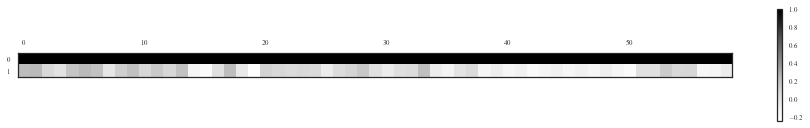

In [55]:
plt.matshow(pm_first_component_all_one.dim_reducer_preprocessing.components_)
plt.colorbar()